In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
tidy_data = pd.read_csv('tidy.csv')
X_data = tidy_data.drop(['CHT_No', 'reStroke'], axis=1)
X_data = X_data.drop(['Adm_AF_0otEKG', 'EKG_AF', 'Adm_AntiCO'], axis=1) # highly related to AF
y_data = tidy_data[['reStroke']]

In [3]:
# remove constant features
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0)
selector.fit(X_data)
X_data = X_data[X_data.columns[selector.get_support(indices=True)]]

In [4]:
categorical_ix = [0, 2, 3, 4, 5, 6, 7, 8, 34, 35, 36, 41, 42, 43, 44, 46, 47, 48, 49, 51]
# if not remove highly related to AF
# categorical_ix = [0, 2, 3, 4, 5, 6, 7, 8, 34, 35, 36, 37, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 55]
categorical_columns = X_data.columns[categorical_ix].values
numerical_columns =  np.setdiff1d(X_data.columns, categorical_columns)

In [5]:
print(X_data.head())
print(categorical_columns)
print(numerical_columns)

   Sex   Age  HTN   DM  Dyslipidemia   AF  CVA_Hx  CT_Old_Lesion  Smoking  \
0  0.0  84.0  0.0  0.0           1.0  1.0     1.0            1.0      0.0   
1  1.0  83.0  1.0  1.0           0.0  0.0     1.0            1.0      0.0   
2  0.0  44.0  0.0  0.0           0.0  1.0     0.0            0.0      0.0   
3  0.0  67.0  1.0  1.0           1.0  1.0     0.0            0.0      0.0   
4  0.0  86.0  1.0  1.0           0.0  1.0     0.0            0.0      0.0   

   WBC  ...  Marriage  Sleep  CT_0ew_Lesio0  Alcohol  BU0-Cr Ratio  BUN-Cr  \
0  9.2  ...       1.0    1.0            0.0      0.0         28.57     1.0   
1  8.5  ...       1.0    0.0            0.0      0.0         20.63     1.0   
2  4.9  ...       0.0    0.0            0.0      0.0          4.69     0.0   
3  8.3  ...       1.0    1.0            1.0      0.0         13.33     0.0   
4  7.7  ...       1.0    0.0            0.0      0.0         18.47     0.0   

   Glucose  NIHSS_Dis  BI_Dis  MRS_Dis  
0    133.0       31.0     0

In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

X_data[numerical_columns] = StandardScaler().fit_transform(X_data[numerical_columns])
# one-hot
X_data_one_hot = pd.get_dummies(X_data, columns=categorical_columns)
# BTW, if want to do dummy
# X_data_dummy = pd.get_dummies(X_data, columns=categorical_columns, , drop_first=True)

In [7]:
import distython
heom_metric = distython.HEOM(X_data, categorical_ix, nan_equivalents = [np.nan])

# UMAP-euclidean

C:\Users\USER\anaconda3\envs\reStroke\lib\site-packages\umap\__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


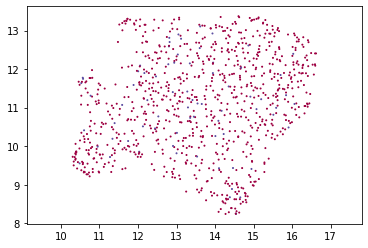

In [8]:
import umap
reducer = umap.UMAP(random_state=369)
umap_embedding = reducer.fit_transform(X_data_one_hot)
plt.clf()
plt.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c=y_data.values.astype(int), s=1, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')

# UMAP-HEOM

C:\Users\USER\anaconda3\envs\reStroke\lib\site-packages\umap\umap_.py:1728: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


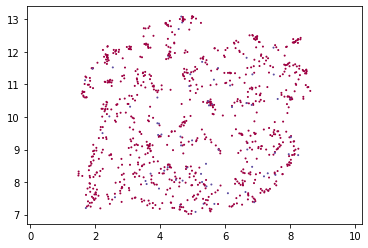

In [9]:
reducer = umap.UMAP(metric = heom_metric.heom, random_state=369)
umap_heom_embedding = reducer.fit_transform(X_data)
plt.clf()
plt.scatter(
    umap_heom_embedding[:, 0],
    umap_heom_embedding[:, 1],
    c=y_data.values.astype(int), s=1, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')

# T-SNE-euclidean

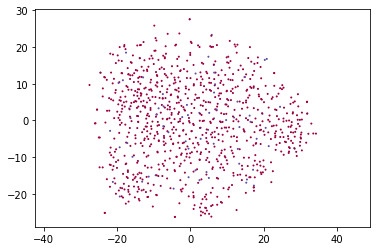

In [10]:
from sklearn.manifold import TSNE
tsne_embedding = TSNE(n_components=2, perplexity=30, random_state=369).fit_transform(X_data_one_hot)
plt.clf()
plt.scatter(
    tsne_embedding[:, 0],
    tsne_embedding[:, 1],
    c=y_data.values.astype(int), s=1, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')


# T-SNE-HEOM

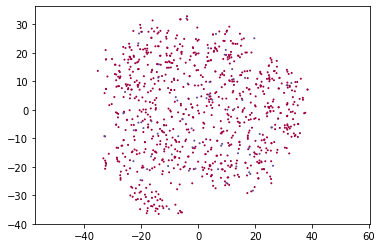

In [11]:
tsne_heom_embedding = TSNE(n_components=2, perplexity=30, metric = heom_metric.heom, random_state=369).fit_transform(X_data)
plt.clf()
plt.scatter(
    tsne_heom_embedding[:, 0],
    tsne_heom_embedding[:, 1],
    c=y_data.values.astype(int), s=1, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')

## Add cluster labels

In [18]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan, DBSCAN, SpectralClustering
# 需要繼續調參增加類別，有兩個方向都是可以的，一個是繼續減少eps，另一個是增加min_samples
import hdbscan
# conda install -c conda-forge hdbscan

7


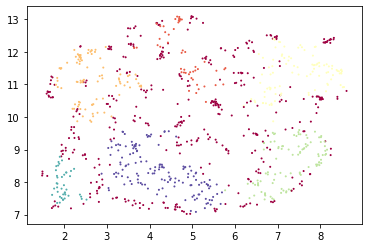

In [26]:
# umap_cluster = DBSCAN(eps = 0.3, min_samples = 10).fit(umap_heom_embedding)
umap_cluster = hdbscan.HDBSCAN(
    min_samples=30,
    min_cluster_size=5,
).fit(umap_heom_embedding)

plt.clf()
plt.scatter(umap_heom_embedding[:, 0],
            umap_heom_embedding[:, 1],
            c=umap_cluster.labels_,
            s=1,
            cmap='Spectral');
tidy_data['umap_label'] = umap_cluster.labels_
print(len(set(umap_cluster.labels_)))

1


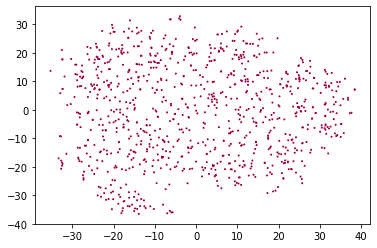

In [36]:
tsne_cluster = DBSCAN(eps = 2, min_samples = 15).fit(tsne_heom_embedding)
# tsne_cluster = hdbscan.HDBSCAN(
#     min_samples=10,
#     min_cluster_size=2,
# ).fit(tsne_heom_embedding)
plt.clf()
plt.scatter(tsne_heom_embedding[:, 0],
            tsne_heom_embedding[:, 1],
            c=tsne_cluster.labels_,
            s=1,
            cmap='Spectral');
tidy_data['tsne_labels'] = tsne_cluster.labels_
print(len(set(tsne_cluster.labels_)))

In [15]:
# label_diff = umap_labels - tsne_labels
# print('diff %.2f%%' %(len(label_diff[label_diff !=0])/len(label_diff)*100))

In [16]:
# tidy_data.to_csv('restroke_cluster_result.csv', index=False)